### Section 4.3: Imaging flat-fields


In [1]:
# Importing necessary packages
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from scipy import stats

In [2]:
def create_median_flat(file_template, start_index, end_index):
    """
    Create a median flat field by median-combining flat field frames.
    
    :param file_template: Template path for the flat field files with placeholders for the frame number.
    :type file_template: str
    :param start_index: The starting index for the flat field frames.
    :type start_index: int
    :param end_index: The ending index for the flat field frames.
    :type end_index: int
    :return: Master flat field (2D np.ndarray), Stack of individual flat field frames (3D np.ndarray)
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # List to store the data from each flat field frame
    flat_fields_data = []
    
    # Loop through each flat field frame and read the data
    for i in range(start_index, end_index + 1):
        # Construct the file name based on the frame number
        file_path = file_template.format(i)
        # Open the FITS file and extract the data
        with fits.open(file_path) as hdul:
            flat_fields_data.append(hdul[0].data)
    
    # Stack the frames into a 3D array (stack of 2D frames)
    stacked_frames = np.stack(flat_fields_data, axis=0)
    # Calculate the median across the stack (axis=0)
    master_flat_frame = np.median(stacked_frames, axis=0)
    
    return master_flat_frame, stacked_frames

# Template for the file names (with placeholder)
file_template = r"..\FITS_Files\3.3.4_3_flat_fields_10_sec_RED.{:08d}.FLAT.FIT"
# Define the starting and ending indices
start_index = 5
end_index = 14
# Create the master flat frame and get the individual frames
master_flat_frame, flat_fields = create_median_flat(file_template, start_index, end_index)

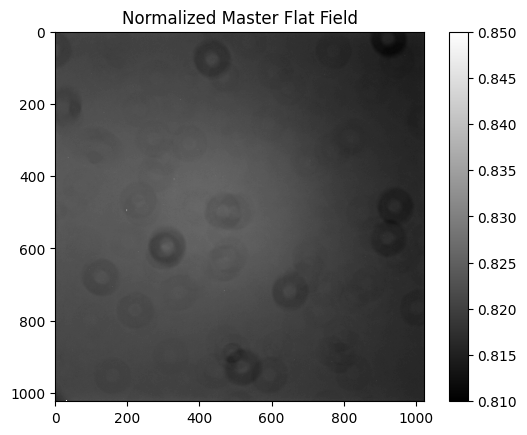

In [24]:
def normalize_flat_field(median_flat_field):
    """
    Normalize the median flat field by dividing by the mode of its pixel values,
    and then scale the normalized flat field to be between 0.8 and 1.10.
    
    :param median_flat_field: The median flat field to be normalized.
    :type median_flat_field: np.ndarray
    :return: Scaled and normalized flat field.
    :rtype: np.ndarray
    """
    # Flatten the median flat field to 1D for mode calculation
    flat_median = median_flat_field.flatten()
    # Calculate the mode of the flattened median values
    mode_value = stats.mode(flat_median, keepdims=True)[0][0]
    # Normalize the median flat field by dividing by the mode
    norm_flat = median_flat_field / mode_value
    # Scale to the range [0.8, 1.10]
    min_val = norm_flat.min()
    max_val = norm_flat.max()
    # Rescale to [0, 1] first
    norm_flat_rescaled = (norm_flat - min_val) / (max_val - min_val)
    # Then scale to [0.8, 1.10]
    scaled_norm_flat = 0.8 + 0.3 * norm_flat_rescaled
    # Plot the normalized and scaled flat field
    plt.imshow(scaled_norm_flat, cmap='gray', vmin=0.81, vmax=0.85)
    plt.colorbar()
    plt.title("Normalized Master Flat Field")
    plt.show()

    # Save the scaled normalized flat field as a FITS file
    hdu = fits.PrimaryHDU(scaled_norm_flat)
    file_path = r"C:\Users\misha\OneDrive\Desktop\AST_443_Resources\scaled_norm_flats.fits" # change this file to your specifications
    hdu.writeto(file_path, overwrite=True)
    
    return scaled_norm_flat

scaled_norm_flat = normalize_flat_field(master_flat_frame)

In [5]:
# for each norm value, I assumed a circular region with radius of 50 pixels in ds9
center_norm = 0.824091
# first: (0, 0), second: (1024, 0), thrid: (0, 1024), fourth: (1024, 1024)
corner_values =  np.array([0.819755, 0.815068, 0.820093, 0.816347])

brightest_norm = 0.822276 # (682.0352, 522.368) 
darkest_norm = 0.821834 # (315.008, 597.0176)

# Calculate the average value of the corner norms
average_corner_norm = np.mean(corner_values)

# Calculate the ratio of brightness between brightest and darkest areas
bright_dark_ratio = brightest_norm / darkest_norm

# Calculate the ratio of the center norm to the average corner norm
center_corner_ratio = center_norm / average_corner_norm

# Calculate the magnitude difference
loc_norm_ratio = center_corner_ratio
loc_mag = -2.5 * np.log10(loc_norm_ratio)

# Print results
print(f"Average norm of the corners: {average_corner_norm:.6f}")
print(f"Ratio of brightness between the brightest and darkest areas: {bright_dark_ratio:.5f}")
print(f"Difference in magnitude between the center and average corner values: {loc_mag:.5f}")

Average norm of the corners: 0.817816
Ratio of brightness between the brightest and darkest areas: 1.00054
Difference in magnitude between the center and average corner values: -0.00830


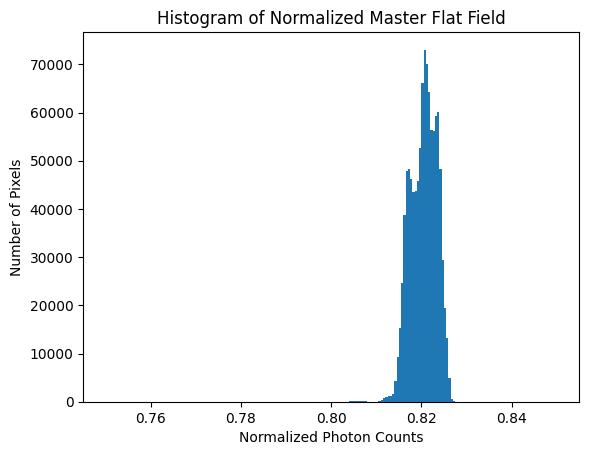

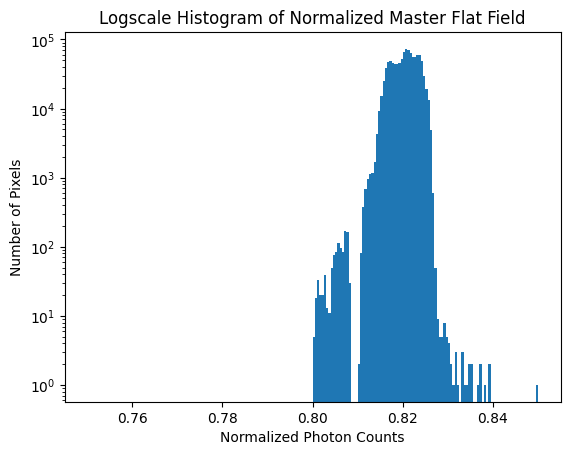

In [25]:
# Plot histogram on linear scale
plt.hist(norm_flat.flatten(), range=(0.75, 0.85), bins=200)
plt.xlabel('Normalized Photon Counts')
plt.ylabel('Number of Pixels')
plt.title('Histogram of Normalized Master Flat Field')
plt.show()

# Plot histogram on log scale
plt.hist(norm_flat.flatten(), range=(0.75, 0.85), bins=200, log=True)
plt.xlabel('Normalized Photon Counts')
plt.ylabel('Number of Pixels')
plt.title('Logscale Histogram of Normalized Master Flat Field')
plt.show()